In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools
using Random

In [2]:
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [ ]:
truth = (σy = 0.6, σang = 0.3, xw = 2)
n = 10^3

In [ ]:
data = (y0 = rand(Normal(0.0, truth.σy), n), ang = rand(Normal(0.0, truth.σang), n),);

In [ ]:
pred(x, waist, y, ang) = y .+ ang .* (x-waist)

In [ ]:
x = -10:10
y = [pred(x_r, truth.xw, data.y0, data.ang) for x_r in x]
y_std = [std(y_tmp) for y_tmp in y]

truth_env = sqrt.(truth.σy^2 .+ truth.σang.^2 .* (x .- truth.xw).^2 )

fig, ax= plt.subplots(1,1, figsize=(7,7))

for i in 1:n
    y_run = [y_tmp[i] for y_tmp in y]
    ax.plot(x, y_run, color="gray", alpha=0.1)
end

ax.plot(x, truth_env, color="red", alpha=0.9)
ax.plot(x, y_std, color="orange", alpha=0.9, ls=":")


In [ ]:
fit_data = (x = [x[i] for i in [1,7,14,20]], y = [fit(Histogram, y[i], nbins=20) for i in [1,7,14,20]]);

In [ ]:
function log_lik(; data = fit_data)
    
    return params -> begin   
        
        ll = 0.0
        σ_vect = sqrt.(params.σy^2 .+ params.σang.^2 .* (data.x .- params.xw).^2 )
        
        for i in 1:4
            y_pred = params.I[i] * pdf.(Normal.(params.μ[i], σ_vect[i]), midpoints(data.y[i].edges[1]))
            ll += sum(logpdf.(Normal.(y_pred, params.fluct[i]), data.y[i].weights ))
        end
        
        return LogDVal(ll)
    end
        
end

log_likelihood = log_lik()

In [ ]:
prior_ang = NamedTupleDist(
    μ = [-5 .. 5, -5 .. 5, -5 .. 5, -5 .. 5],
    fluct = [0 .. 10^3, 0 .. 10^3, 0 .. 10^3, 0 .. 10^3],
    I = [0 .. 10^4 for i in 1:4],
    σy = 0 .. 2,
    σang = 0 .. 2,
    xw = -5 .. 5,
);

In [ ]:
par_tmp = rand(prior_ang)

In [ ]:
log_likelihood(par_tmp)

In [ ]:
iter = 8000
iter_warmup = 500
chains = 4;

In [ ]:
posterior = PosteriorDensity(log_likelihood, prior_ang);

In [ ]:
posterior_is = bat_transform(PriorToGaussian(), posterior, PriorSubstitution()).result;

In [ ]:
metric = BAT.DiagEuclideanMetric()
integrator = BAT.LeapfrogIntegrator()
proposal = BAT.NUTS(:MultinomialTS, :ClassicNoUTurn)
adaptor = BAT.StanHMCAdaptor(0.8, iter_warmup)
hmc_sampler = HamiltonianMC(metric, ForwardDiff, integrator, proposal, adaptor); #HamiltonianMC

In [ ]:
@time samples_is = bat_sample(posterior_is, MCMCSampling(nsteps = iter, mcalg = hmc_sampler, nchains = chains, strict=false));

In [ ]:
samples = samples_is.result;

In [ ]:
trafo_is = trafoof(posterior_is.likelihood)
samples = inv(trafo_is).(samples);

In [ ]:
sz = size(flatview(unshaped.(samples.v)))

In [ ]:
param_mode = mode(samples)

In [ ]:
dims = 1:15
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 30

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

## Plot of the Crossection: 

In [3]:
pred(s, sw, sigma, sigma_ang) = sigma .+ sigma_ang .* (s-sw)*1000

pred (generic function with 1 method)

In [8]:
truth = (σ = 0.2, σp = 4.0*10^-5, sw = 2.774)

n = 10^3
s = range(0.0, stop=25,length=50)

data = (σx = rand(Normal(0.0, truth.σ), n), σy = rand(Normal(0.0, truth.σ), n), σpx = rand(Normal(0.0, truth.σp), n), σpy = rand(Normal(0.0, truth.σp), n));

x = [pred(sr, truth.sw, data.σx, data.σpx) for sr in s]
y = [pred(sr, truth.sw, data.σy, data.σpy) for sr in s];

y_std = [std(y_tmp) for y_tmp in y]
x_std = [std(x_tmp) for x_tmp in x]

r_std = sqrt.(y_std.^2 .+ x_std.^2)

x = hcat(x...)
y = hcat(y...);

In [12]:
theta = range(0, stop = 2*pi, length=15)
    
theta_grid = ones(length(s)) * theta'
zgrid = s * ones(length(theta))'

truth_env = sqrt(2)*sqrt.(truth.σ^2 .+ 10^6*truth.σp.^2 .* (s .- truth.sw).^2)

xgrid = truth_env .* cos.(theta_grid) .+ 0.0
ygrid = truth_env .* sin.(theta_grid) .+ 0.0;

xgrid_approx = r_std .* cos.(theta_grid) .+ 0.0
ygrid_approx = r_std .* sin.(theta_grid) .+ 0.0;

In [13]:
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

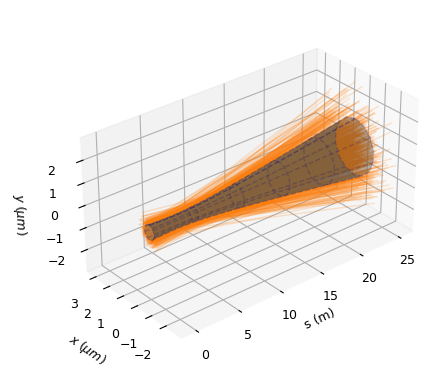

In [15]:
fig = plt.figure(figsize=(5.905631659056317, 4.724505327245054))
ax = fig.add_subplot(111, projection="3d")

for i in 1:n
    ax.plot(s, x[i,:], y[i,:],
        lw=1.0,
        color="C1",  # charge_norm[i] pol_ang_log
        "-", 
        alpha=0.2, 
    )  
end

ax.plot_surface(zgrid, ygrid, xgrid, alpha=0.3, color="C0")

ax.plot_wireframe(zgrid, ygrid_approx, xgrid_approx, alpha=0.2, color="navy", rstride=10, cstride=2, linestyles="dashed", lw=1)

ax.set_box_aspect((20, 10, 10))
ax.set_xlabel("s (m)")
ax.set_ylabel(L"x \; (μm)")
ax.set_zlabel(L"y \; (μm)")

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.5))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.5))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.5))

ax.w_xaxis.gridlines.set_lw(0.1)
ax.w_yaxis.gridlines.set_lw(0.1)
ax.w_zaxis.gridlines.set_lw(0.1)


ax.view_init(30, -130)

# fig.savefig("../plots/envelope-example.png", bbox_inches = "tight", dpi=500)

In [16]:
sqrt(2) * 4.0*10^-5

5.656854249492382e-5